In [1]:
!pip install duckdb --no-index --find-links=file:///kaggle/input/polars-and-duckdb/kaggle/working/mysitepackages/duck_pkg

Looking in links: file:///kaggle/input/polars-and-duckdb/kaggle/working/mysitepackages/duck_pkg
Processing /kaggle/input/polars-and-duckdb/kaggle/working/mysitepackages/duck_pkg/duckdb-0.8.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
import os
import polars as pl
import duckdb as dd
from tqdm import tqdm
import matplotlib.pyplot as plt
import cv2
from pydicom import dcmread
import warnings
from sklearn.preprocessing import LabelEncoder
import pickle
import gc
import ctypes
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

2024-08-05 10:20:22.479057: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-05 10:20:22.479156: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-05 10:20:22.579819: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
with open("/kaggle/input/left-neural-foraminal-narrowing-training/left_neural_foraminal_narrowing_l1_l2_training_features", "rb") as file:
    extracted_training_features = pickle.load(file)
    
with open("/kaggle/input/left-neural-foraminal-narrowing-training/left_neural_foraminal_narrowing_l1_l2_feature_metadata_labels", "rb") as file:
    labels = pickle.load(file)

In [4]:
extracted_training_features_resized = []

for img in extracted_training_features:
    extracted_training_features_resized.append(np.resize(img,(128,)))
    
final = np.array(extracted_training_features_resized)
labels_vstacked = np.vstack(labels)

print(final.shape)
print(labels_vstacked.shape)

(147083, 128)
(147083, 1)


In [10]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[128]))
model.add(keras.layers.Dense(150, activation="relu"))
model.add(keras.layers.Dense(65, activation="relu"))
model.add(keras.layers.Dense(3, activation="softmax"))

In [11]:
x_train, x_test, y_train, y_test = train_test_split(final, labels_vstacked, test_size=0.3, random_state=42)
x_test, x_valid, y_test, y_valid = train_test_split(x_test, y_test, test_size=0.2, random_state=42)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print(x_valid.shape)
print(y_valid.shape)

(102958, 128)
(102958, 1)
(35300, 128)
(35300, 1)
(8825, 128)
(8825, 1)


In [12]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [13]:
history = model.fit(x_train, y_train, epochs=123, validation_data=(x_valid, y_valid))

Epoch 1/123
 111/3218 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.8708 - loss: 16.7132       

I0000 00:00:1722853494.909197     124 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3218/3218 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9369 - loss: 2.7927 - val_accuracy: 0.9641 - val_loss: 0.1923
Epoch 2/123
3218/3218 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.9616 - loss: 0.1934 - val_accuracy: 0.9648 - val_loss: 0.1566
Epoch 3/123
3218/3218 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.9625 - loss: 0.1710 - val_accuracy: 0.9648 - val_loss: 0.1551
Epoch 4/123
3218/3218 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9629 - loss: 0.1634 - val_accuracy: 0.9648 - val_loss: 0.1555
Epoch 5/123
3218/3218 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9621 - loss: 0.1660 - val_accuracy: 0.9648 - val_loss: 0.1551
Epoch 6/123
3218/3218 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.9627 - loss: 0.1636 - val_accuracy: 0.9648 - val_loss: 0.1555
Epoch 7/123
3218/3218 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.9633 - loss: 0.1613 - val_accuracy: 0.9648 - val_loss: 0.2022
Epoch 8/123
3218/3218 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9628 - loss: 0.1642 - val_

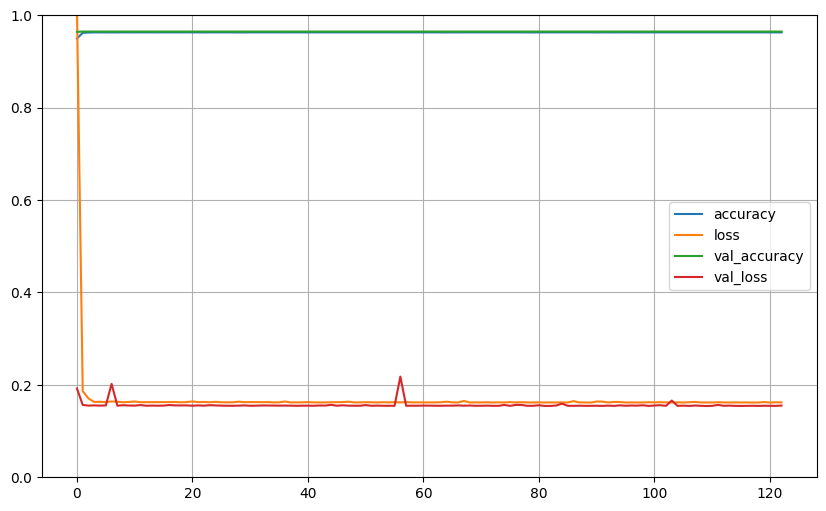

In [14]:
pd.DataFrame(history.history).plot(figsize=(10,6))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [15]:
model.evaluate(x_test, y_test)

1104/1104 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9629 - loss: 0.1631


[0.16080813109874725, 0.9633994102478027]

In [16]:
model.save("keras_base_left_neural_foraminal_narrowing_l1_l2.h5")